In [8]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
import keras
from collections import Counter

In [2]:
print(os.listdir("/kaggle/input/mask-rcnn-coco"))
DATA_DIR = '/kaggle/input'
# Directory to save logs and trained model
ROOT_DIR = '/kaggle/working'

!pip install mask-rcnn-12rics
!git clone https://github.com/matterport/Mask_RCNN
os.chdir('Mask_RCNN')
# !python setup.py install
# # Import Mask RCNN
# sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
# os.chdir(ROOT_DIR)
train_dicom_dir = os.path.join(DATA_DIR, 'rsna-pneumonia-detection-challenge/stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'rsna-pneumonia-detection-challenge/stage_2_test_images')

['mask_rcnn_coco.h5']
     |████████████████████████████████| 61kB 6.6MB/s eta 0:00:011
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 40.34 MiB/s, done.
Resolving deltas: 100% (558/558), done.


# **Завантаження та візуалізація даних**

In [3]:
classes = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
train_label_df = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
final_df = pd.concat([train_label_df, classes['class']], axis = 1)

In [4]:
train_img_size = 256 
origin_img_size = 1024
scale_factor = train_img_size / origin_img_size
isna_count = len(train_label_df[train_label_df.Target == 0])
train_label_df = train_label_df[train_label_df.Target == 1]
train_label_df.rename(columns={"x": "X0", "y": "Y0"}, inplace=True)
train_label_df["X1"] = train_label_df["X0"] + train_label_df["width"]
train_label_df["Y1"] = train_label_df["Y0"] + train_label_df["height"]
train_label_df[["X0", "X1", "Y0", "Y1"]] = train_label_df[["X0", "X1", "Y0", "Y1"]] * scale_factor
train_label_df["area"] = train_label_df["width"] * scale_factor * train_label_df["height"] * scale_factor
train_label_df.drop(["width", "height"], axis=1, inplace=True)
train_label_df.head()

,patientId,X0,Y0,Target,X1,Y1,area
4,00436515-870c-4b36-a041-de91049b9ab4,66.00,38.00,1,119.25,132.75,5045.4375
5,00436515-870c-4b36-a041-de91049b9ab4,140.50,38.00,1,204.50,151.25,7248.0000
8,00704310-78a8-4b38-8475-49f4573b2dbb,80.75,144.25,1,120.75,170.25,1040.0000
9,00704310-78a8-4b38-8475-49f4573b2dbb,173.75,143.75,1,214.25,178.00,1387.1250
14,00aecb01-a116-45a2-956c-08d2fa55433f,72.00,80.50,1,95.50,114.25,793.1250


In [5]:
class DataPreprocessing:
    def __init__(self):
        self.custom_fig = None
        self.custom_ax = None
        self.fig = None
    
    def build_percentage_bar(self, classes):
        f, ax = plt.subplots(1, 1, figsize=(15, 5))
        total = float(len(classes))
        classes.groupby('class').size().plot.bar(color='skyblue')
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 3, f'{int(100 * height / total)} %', ha='center', bbox=dict(facecolor='red', alpha=0.5))
        plt.show()
        
    def build_class_target(self, final_df):
        self.custom_fig, self.custom_ax = plt.subplots(nrows=1, figsize=(12, 6))

        custom_temp = final_df.groupby('Target')['class'].value_counts()
        custom_data_target_class = pd.DataFrame(data={'Values': custom_temp.values}, index=custom_temp.index).reset_index()

        sns.barplot(ax=self.custom_ax, x='Target', y='Values', hue='class', data=custom_data_target_class, palette='Set2')

        plt.title('Клас і цільовий розподіл')
        plt.show()
    
    def build_box_frequency(self, train_label_df, isna_count):
        cnt = Counter(train_label_df.patientId)
        sample_batch = [sample[0] + ".dcm" for sample in cnt.most_common(2)]
        counts = pd.Series(list(cnt.values())).value_counts()
        counts[0] = isna_count

        plt.figure(figsize=(10, 6))
        plt.title("Частота обмежуючих рамок")
        plt.ylabel("Кількість")
        plt.xticks(counts.index)
        plt.bar(counts.index, counts, color='skyblue')
        plt.show()
    
    def build_area_analysis(self, train_label_df):
        fig, axs = plt.subplots(1, 2, figsize=(18, 5))

        # Гістограма
        axs[0].hist(train_label_df["area"], color='skyblue')
        axs[0].set_xlabel("Площа")
        axs[0].set_ylabel("Кількість")
        axs[0].set_title("Гістограма площі")

        # Boxplot
        axs[1].boxplot(train_label_df["area"])
        axs[1].set_ylabel("Площа")
        axs[1].set_title("Боксплот площі")

        plt.show()

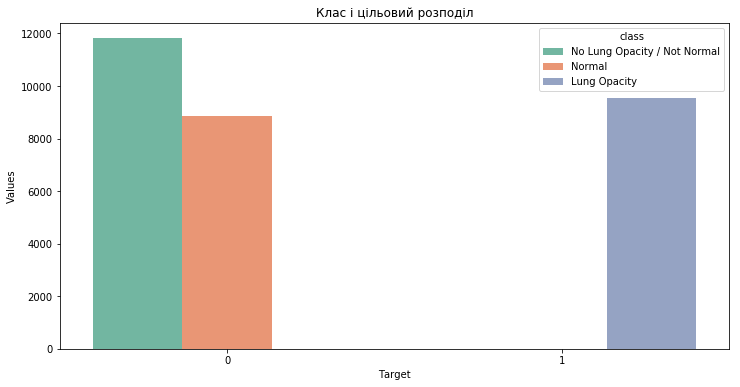

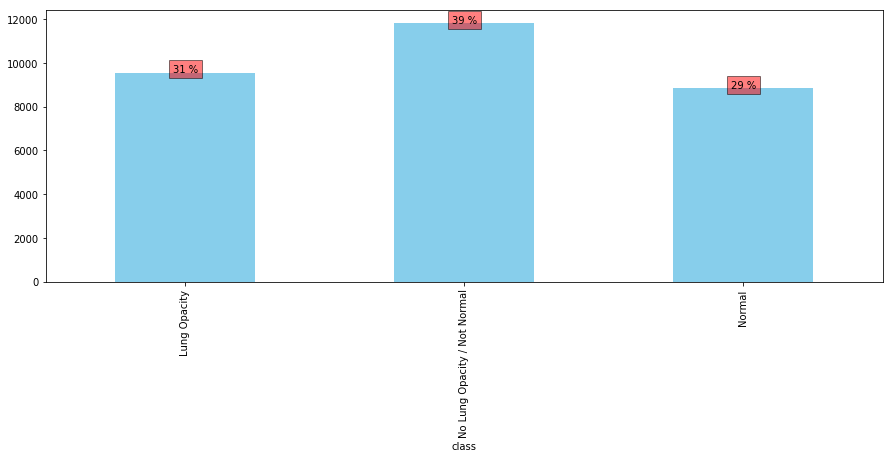

In [6]:
graph_builder = DataPreprocessing()

graph_builder.build_class_target(final_df)
graph_builder.build_percentage_bar(classes)

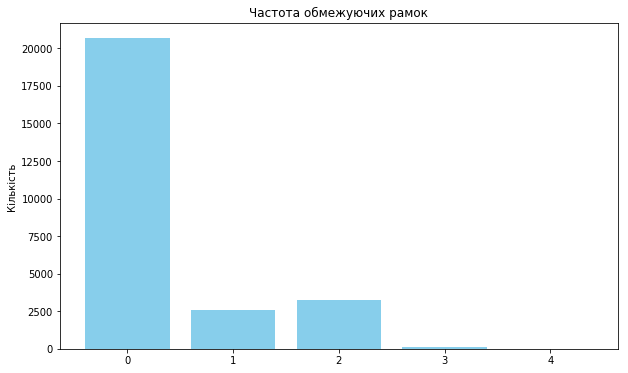

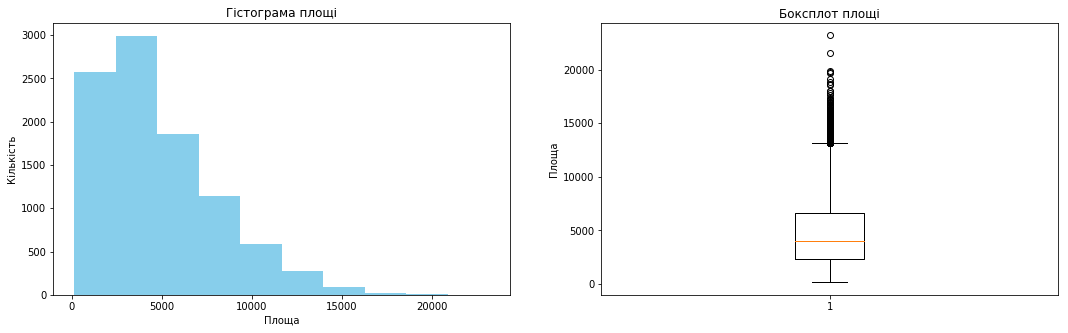

In [9]:
graph_builder.build_box_frequency(train_label_df, isna_count)
graph_builder.build_area_analysis(train_label_df)

#  **Передобробка даних**

In [10]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 


class DetectorConfig(Config):
    """
    Конфігурація основних параметрів
    """ 
    NAME = 'pneumonia'
    GPU_COUNT = 1
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200    
    
config = DetectorConfig() 
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [11]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, paths_to_images, annotations_per_image, image_height, image_width):
        # Виклик конструктора базового класу
        super().__init__()

        # Додавання класу "Легенева непрозорість" до набору даних
        self.add_class('pneumonia', 1, 'Lung Opacity')

        # Додавання інформації про зображення в набір даних
        for index, image_path in enumerate(paths_to_images):
            # Отримання анотацій для конкретного зображення
            current_annotations = annotations_per_image[image_path]
            # Додавання зображення та його анотацій в набір даних
            self.add_image(
                'pneumonia',  # Джерело даних
                image_id=index, 
                path=image_path,  
                annotations=current_annotations,  
                orig_height=image_height,  
                orig_width=image_width 
            )

    def image_reference(self, image_id):
        image_info = self.image_info[image_id]
        # Повертаємо шлях до зображення
        return image_info['path']

    def load_image(self, image_id):
        # Отримання інформації про зображення за ID
        image_info = self.image_info[image_id]
        # Шлях до файлу зображення
        image_path = image_info['path']
        # Завантаження DICOM файла
        dicom_file = pydicom.read_file(image_path)
        # Перетворення DICOM у numpy масив
        image_array = dicom_file.pixel_array
        # Якщо зображення в градаціях сірого, конвертуємо у RGB для уніфікації
        if len(image_array.shape) != 3 or image_array.shape[2] != 3:
            image_array = np.stack((image_array,) * 3, axis=-1)
        # Повертаємо зображення
        return image_array

    def load_mask(self, image_id):
        # Отримання детальної інформації про зображення за його ідентифікатором
        image_details = self.image_info[image_id]
        # Витягуємо анотації, пов'язані з цим зображенням
        image_annotations = image_details['annotations']
        # Кількість анотацій
        annotations_count = len(image_annotations)
        # Ініціалізація маски та масиву ідентифікаторів класів
        if annotations_count == 0:
            # Створення порожньої маски, якщо анотацій немає
            mask = np.zeros((image_details['orig_height'], image_details['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            # Створення маски з анотаціями
            mask = np.zeros((image_details['orig_height'], image_details['orig_width'], annotations_count), dtype=np.uint8)
            class_ids = np.zeros((annotations_count,), dtype=np.int32)
            for idx, annotation in enumerate(image_annotations):
                if annotation['Target'] == 1:
                    # Координати об'єкта анотації
                    rect_start_x = int(annotation['x'])
                    rect_start_y = int(annotation['y'])
                    rect_width = int(annotation['width'])
                    rect_height = int(annotation['height'])
                    # Створення індивідуальної маски для анотації
                    individual_mask = mask[:, :, idx].copy()
                    cv2.rectangle(individual_mask, (rect_start_x, rect_start_y), (rect_start_x + rect_width, rect_start_y + rect_height), 255, -1)
                    mask[:, :, idx] = individual_mask
                    class_ids[idx] = 1
        # Конвертація типу маски для використання у подальшій обробці
        return mask.astype(np.bool_), class_ids.astype(np.int32)

In [12]:
# тренувальний набір
anns = pd.read_csv(os.path.join(DATA_DIR, 'rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'))
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [13]:
# Оригінальні DICOM картинки розміру: 1024 x 1024
ORIG_SIZE = 1024
ds = pydicom.read_file(image_fps[0]) 
image = ds.pixel_array 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.17160.1517874402.585650
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: 'e0ebab86-6a6f-4209-a297-22a4fe46e7f2'
(0010, 0020) Patient ID                          LO: 'e0ebab86-6a6f-4209-a297-22a4fe46e7f2'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [14]:
######################################################################
# Модифікуйте цей рядок, щоб використовувати більше або менше зображень для тренування/валідації.
# Щоб використати всі зображення, використовуйте: image_fps_list = list(image_fps)
#image_fps_list = list(image_fps[:1000]) # Для прикладу, якщо потрібно обмежити кількість до 1000 зображень
image_fps_list = list(image_fps)
#####################################################################

# Розділення набору даних на тренувальний та валідаційний
# Співвідношення розділення встановлене як 0.9 проти 0.1 
# 0.8 проти 0.2 # для альтернативного варіанта розділення
sorted(image_fps_list)  # Сортування списку зображень
random.seed(42) 
random.shuffle(image_fps_list)  

validation_split = 0.1 
#validation_split = 0.2  
split_index = int((1 - validation_split) * len(image_fps_list))  # Обчислення індексу, за яким відбудеться розділення

image_fps_train = image_fps_list[:split_index]  
image_fps_val = image_fps_list[split_index:]  

print(len(image_fps_train), len(image_fps_val))  

24015 2669


In [15]:
# підготовка тренувального набору
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [16]:
# вивід прикладів анотацій
#test_fp = random.choice(image_fps_train) #xhb 20190525
test_fp='ef9fb572-2914-4d16-982a-59eb99f5567b.dcm'
image_annotations[DATA_DIR+'/rsna-pneumonia-detection-challenge/stage_2_train_images/'+test_fp]

[patientId    ef9fb572-2914-4d16-982a-59eb99f5567b
 x                                             275
 y                                             250
 width                                         161
 height                                        196
 Target                                          1
 Name: 26928, dtype: object]

In [17]:
# підготовка валідаційного набору
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [18]:
# # Іллюстр
# # Suggestion: Run this a few times to see different examples. 

# image_id = random.choice(dataset_train.image_ids)
# image_fp = dataset_train.image_reference(image_id)
# image = dataset_train.load_image(image_id)
# mask, class_ids = dataset_train.load_mask(image_id)

# print(image.shape)

# plt.figure(figsize=(10, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(image[:, :, 0], cmap='gray')
# plt.axis('off')
# plt.subplot(1, 2, 2)
# masked = np.zeros(image.shape[:2])
# for i in range(mask.shape[2]):
#     masked += image[:, :, 0] * mask[:, :, i]
# plt.imshow(masked, cmap='gray')
# plt.axis('off')

# print(image_fp)
# print(class_ids)

# **Тренування моделі**
Завантаження моделі з попередньо визначеними вагами та встановлення зворотніх викликів для зберігання моделі.

In [19]:


# Аугментація зображень (вирівненя контрастності)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## геометрична трасфрпмація
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## яскравість та кон
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ 
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
print(model.model_dir)
NUM_EPOCHS =100 # 2, для тесту
COCO_WEIGHTS_PATH = "/kaggle/input/mask-rcnn-coco/mask_rcnn_coco.h5"
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

# Тренування моделі Mask-RCNN  
import warnings 
warnings.filterwarnings("ignore")

# Callbacks
checkpoint_path = os.path.join(ROOT_DIR, "mask_rcnn_{}_*epoch*.h5".format(config.NAME.lower()))
checkpoint_path = checkpoint_path.replace("*epoch*", "{epoch:04d}")
callbacks = [keras.callbacks.ModelCheckpoint(checkpoint_path,verbose=0, save_weights_only=True,period=5)]
    
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            custom_callbacks=callbacks,
            layers='all',
            augmentation=augmentation
           )

/kaggle/working

Starting at epoch 0. LR=0.001

Checkpoint Path: /kaggle/working/pneumonia20240211T1835/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

# **Вибір найкращих вагівмоделі зі збережених.**

In [63]:
# Вибір навченої моделі
# Отримання списку директорій моделі
#dir_names = next(os.walk(model.model_dir))[1]
dir_names=[]
for root, dirs, files in os.walk(model.model_dir):
    for name in files:
        dir_names.append(name)
# key = config.NAME.lower()

# Ключ для пошуку моделей за назвою
key='mask_rcnn'
# print('key is:',key)
# print(dir_names)

# Фільтрація та сортування директорій за ключем
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)
# print(dir_names)

# Перевірка наявності директорій моделі
# if not dir_names:
#     import errno
#     raise FileNotFoundError(
#         errno.ENOENT,
#         "Could not find model directory under {}".format(model.model_dir))
 
# fps = []
# # Pick last directory
# for d in dir_names: 
#     dir_name = os.path.join(model.model_dir, d)
#     # Find the last checkpoint
#     checkpoints = next(os.walk(dir_name))[2]
#     checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
#     checkpoints = sorted(checkpoints)
#     if not checkpoints:
#         print('No weight files in {}'.format(dir_name))
#     else:
#         checkpoint = os.path.join(dir_name, checkpoints[-1])
#         fps.append(checkpoint)

# model_path = sorted(fps)[-1]

#!!!!!! розкоментувати при тренуванні моделі       
model_path=dir_names[-1]
print('Found model {}'.format(model_path))
print(model_path)

In [64]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# перестворення моделі
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

#завантаження заздалегідь натренованої моделі, якщо закоментувати model_path, то завантажиться поточна модель
model_path = "/kaggle/input/model-0090/mask_rcnn_pneumonia_0090.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/input/model-0090/mask_rcnn_pneumonia_0090.h5


# **Приклади роботи на валідаційних наборах.**


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



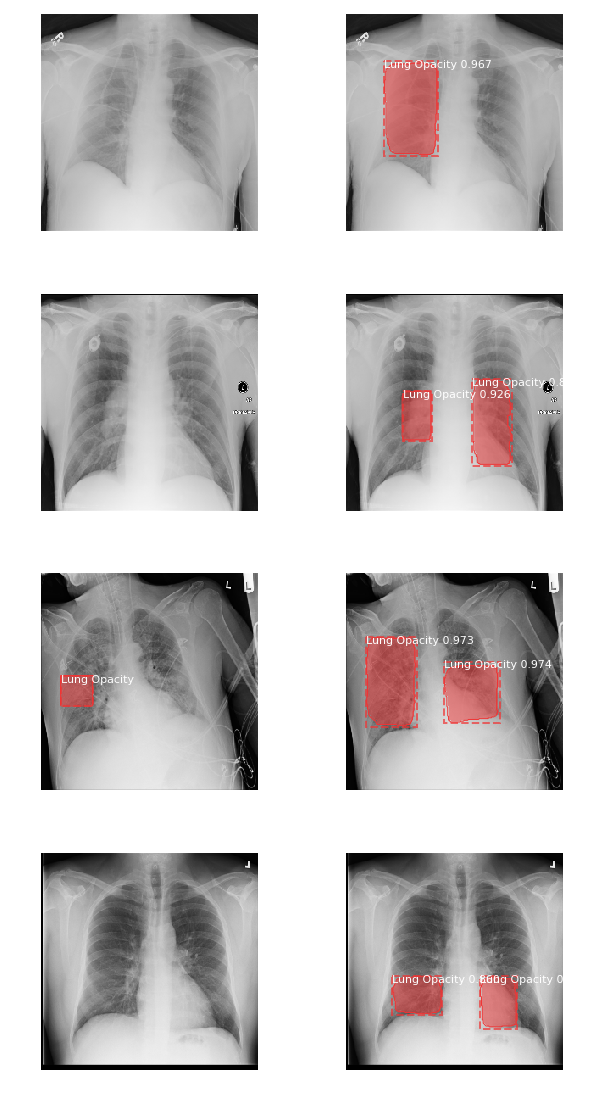

In [65]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [66]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

# Визначення метаданих та записування результатів для кожного зображення у CSV.

In [67]:
# Зробити прогнози на тестових зображеннях, записати зразок подання
def predict(image_fps, filepath=ROOT_DIR+'/submission.csv', min_conf=0.98): 
    # припускаємо квадратне зображення   
    with open(filepath, 'w') as file:
        file.write('patientId,PredictionString'+"\n")        
        for image_id in tqdm(image_fps): 
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
        
            # Якщо в чорно-білому. Конвертуємо в RGB для послідовності
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1) 
            
            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id 
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                out_str += ","
            else: 
                num_instances = len(r['rois'])
                out_str += ","
                for i in range(num_instances): 
                    if r['scores'][i] > min_conf: 
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, ширина, висота 
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1 
                        height = r['rois'][i][2] - y1 
                        bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                          width, height)    
                        out_str += bboxes_str
            file.write(out_str+"\n")

In [68]:
sample_submission_fp = ROOT_DIR+'/submission.csv'
predict(test_image_fps, filepath=sample_submission_fp)
#output = pd.read_csv(sample_submission_fp)
# output.head(50)

100%|██████████| 3000/3000 [07:30<00:00,  8.25it/s]


# **Список використаних джерел:**
<p>github.com/matterport/Mask_RCNN</p>
<p>github.com/i-pan/kaggle-rsna18 </p>
<p>kaggle.com/code/pneumonia-classification-fine-tuning-resnet-83-3 </p>
<p>kaggle.com/code/rsna-pneumonia-detection-cnn-capstone-9 </p>
<p></p>
<p></p>
<p></p>
<p></p>